<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_exercise_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises of Time Series using TensorFlow

This notebook contains the exercises covered for topic Time series forecasting using TensorFlow.


1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
  -  Try doing this for a univariate model (e.g. `model_1`) and a multivariate model (e.g. `model_6`) and see if it effects model training or evaluation results.
2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
  -  You can download the Bitcoin historical data for free from coindesk.com/price/bitcoin and clicking "Export Data" -> "CSV".
3. For most of our models we used `WINDOW_SIZE=7`, but is there a better window size?
  -  Setup a series of experiments to find whether or not there's a better window size.
  -  For example, you might train 10 different models with `HORIZON=1` but with window sizes ranging from 2-12.
4. Create a windowed dataset just like the ones we used for `model_1` using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) and retrain `model_1` using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
  - Are there any other features you think you could add?
  - If so, try it out, how do these affect the model?
6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for `model_8`.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn't retrained for every forecast (`model_9`)?
8. Throughout this notebook, we've only tried algorithms we've handcrafted ourselves. But it's worth seeing how a purpose built forecasting algorithm goes.
  - Try out one of the extra algorithms listed in the modelling experiments part such as:
    - [Facebook's Kats library](https://github.com/facebookresearch/Kats) - there are many models in here, remember the machine learning practioner's motto: experiment, experiment, experiment.
    - [LinkedIn's Greykite library](https://github.com/linkedin/greykite)


In [1]:
# check for gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-428fae02-ad2f-38ab-1568-66a8d109b51b)


## Preparation prior to Exercise

In [2]:
# get the data
!wget https://github.com/SaketMunda/time-series-with-tensorflow/raw/master/BTC-USD-latest.csv

--2023-06-08 03:49:57--  https://github.com/SaketMunda/time-series-with-tensorflow/raw/master/BTC-USD-latest.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD-latest.csv [following]
--2023-06-08 03:49:57--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD-latest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 260918 (255K) [text/plain]
Saving to: ‘BTC-USD-latest.csv’

BTC-USD-latest.csv  100%[===================>] 254.80K  --.-KB/s    in 0.04s   

2023-06-08 03:49:57 (6.36 MB/s) - ‘BTC-USD-latest.c

In [3]:
# importing the data using pandas
import pandas as pd

df = pd.read_csv("BTC-USD-latest.csv", parse_dates=["Date"], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-13,26807.769531,27030.482422,26710.873047,26784.078125,26784.078125,9.999172e+09
2023-05-14,26788.974609,27150.976563,26661.355469,26930.638672,26930.638672,1.001486e+10
2023-05-15,26931.384766,27646.347656,26766.097656,27192.693359,27192.693359,1.441323e+10
2023-05-16,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-17,27023.728516,27223.074219,26987.576172,27110.449219,27110.449219,1.219658e+10


In [5]:
len(df)

3165

In [6]:
len(df)/365

8.67123287671233

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3165 entries, 2014-09-17 to 2023-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3164 non-null   float64
 1   High       3164 non-null   float64
 2   Low        3164 non-null   float64
 3   Close      3164 non-null   float64
 4   Adj Close  3164 non-null   float64
 5   Volume     3164 non-null   float64
dtypes: float64(6)
memory usage: 173.1 KB


let's remove some of the columns first for our experiments, and keep only those who are useful for us.

In [8]:
bitcoin_prices = pd.DataFrame(df['Adj Close']).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-13,26784.078125
2023-05-14,26930.638672
2023-05-15,27192.693359


In [9]:
# check if there is any NaN
bitcoin_prices[bitcoin_prices.Price.isna()]

,Price
Date,
2023-05-16,NaN


Since bitcoin price record is empty so we'll remove the last 2 dates and work only until 15th May 2023 data

In [10]:
bitcoin_prices = bitcoin_prices[:-2]

In [11]:
bitcoin_prices.tail()

,Price
Date,
2023-05-11,27000.789063
2023-05-12,26804.990234
2023-05-13,26784.078125
2023-05-14,26930.638672
2023-05-15,27192.693359


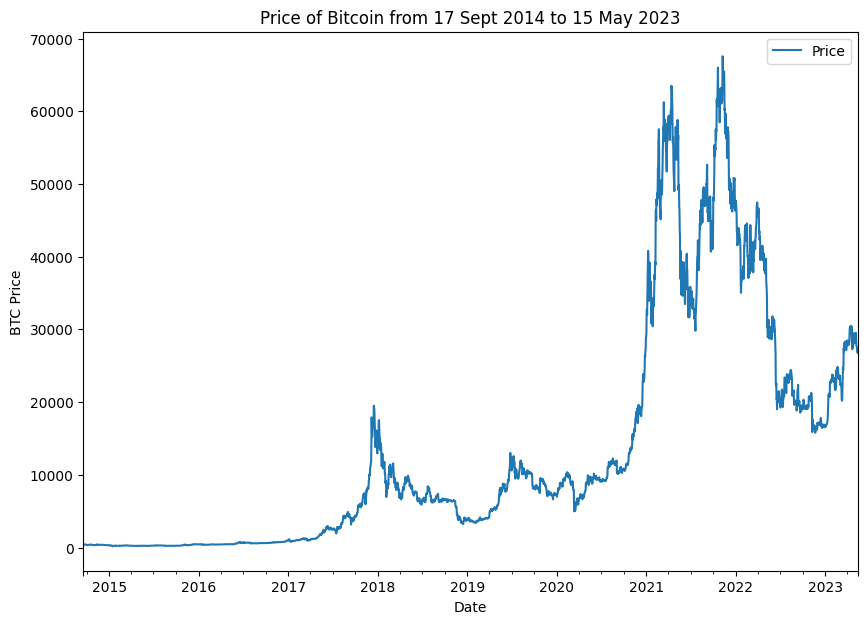

In [12]:
# let's plot the prices
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 15 May 2023");

### Format Data : Part 1 : Create train and test sets for Time series data

In [13]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [14]:
split_size = int(len(timesteps) * 0.8) # 80% train and 20% test set
split_size 

2530

In [15]:
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

Now, we can visualize the data using plot

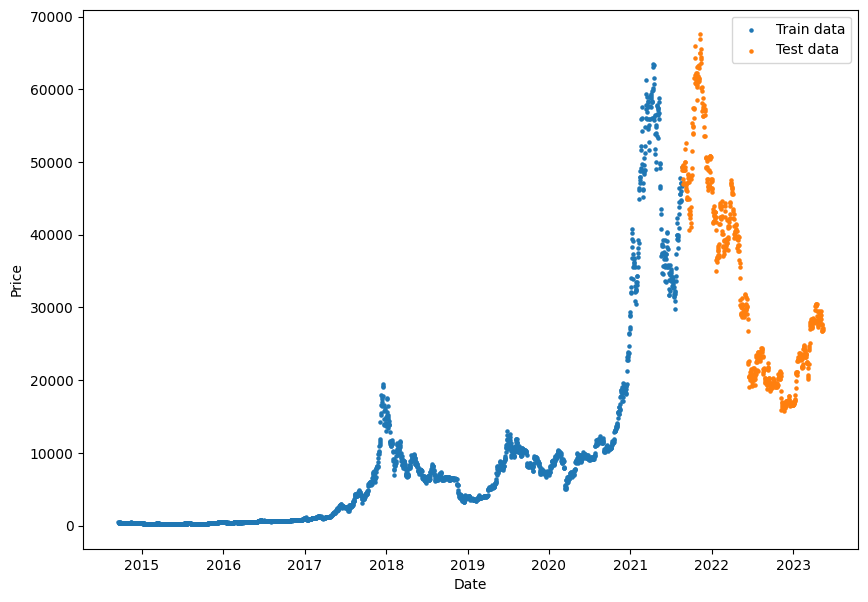

In [16]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

In [17]:
# creating a plotting function, because we need this function to visualize everytime when we do the modelling experiment
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  # plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

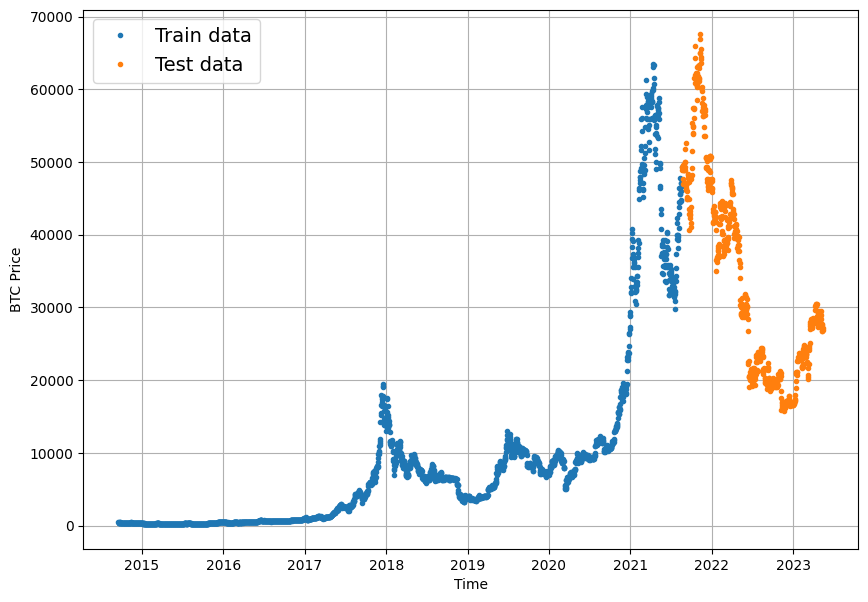

In [18]:
plt.figure(figsize=(10,7))
plot_time_series(X_train,y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

### Format Data Part 2 : Windowing dataset

In [19]:
HORIZON = 1
WINDOW_SIZE = 7

# create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset
  Eg, if horizon=1 (default)
  Input: [1,2,3,4,5,6,7] -> Output: ([1,2,3,4,5,6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [20]:
# let's test it
import tensorflow as tf

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))

test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [21]:
# create a function to create window for entire dataset

import numpy as np

def make_windows(x, window_size=7,horizon=1):
  # 1. Create a window step fo specific window size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # default o/p [[1,2,3,4,5,6,7,8]]

  # 2. Use numpy indexing to create a 2D of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  # default o/p = 

  # 3. Uses the 2D array of multiple window steps to index on a target series
  windowed_array = x[window_indexes]

  # 4. Uses the `get_labelled_windows()` function we create above to turn the window steps into windows with a specified horizon.
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [22]:
# Create a function to create scaled window for entire dataset

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


def make_windows_scaled(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size. Also applied the standard scaler
  """

  scaler.fit(np.expand_dims(x, axis=1))
  scaled_x = scaler.transform(np.expand_dims(x, axis=1))
  scaled_x = np.squeeze(scaled_x)

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  window_indexes = window_step + np.expand_dims(np.arange(len(scaled_x)-(window_size+horizon-1)), axis=0).T
  windowed_array = scaled_x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

## Exercise 1

Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
  -  Try doing this for a univariate model (e.g. `model_1`) and a multivariate model (e.g. `model_6`) and see if it effects model training or evaluation results.

### Scaling Univariate data

In [23]:
scaled_prices = prices / np.max(prices)
scaled_prices

array([0.00676862, 0.00628178, 0.00584304, ..., 0.39640869, 0.39857781,
       0.40245627])

In [24]:
# Let's see how it looks after plotting
from sklearn.preprocessing import minmax_scale
scaled_bitcoin_prices_df = pd.DataFrame(data=scaled_prices,
                                        index=bitcoin_prices.index,
                                        columns=bitcoin_prices.columns)
scaled_bitcoin_prices_df.head()

,Price
Date,
2014-09-17,0.006769
2014-09-18,0.006282
2014-09-19,0.005843
2014-09-20,0.006052
2014-09-21,0.005903


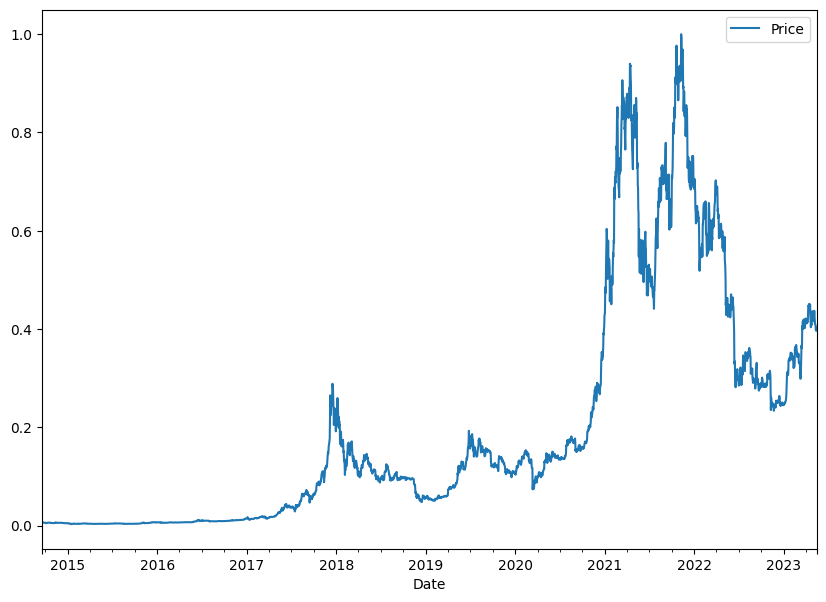

In [25]:
scaled_bitcoin_prices_df.plot(figsize=(10,7));

In [26]:
scaled_full_windows, scaled_full_labels = make_windows(scaled_prices, window_size=WINDOW_SIZE, horizon=HORIZON)

len(scaled_full_windows),len(scaled_full_labels)

(3156, 3156)

In [27]:
# view the first 3 windows/labels
for i in range(3):
  print(f"Windows: {scaled_full_windows[i]}, Labels: {scaled_full_labels[i]}")

Windows: [0.00676862 0.00628178 0.00584304 0.00605185 0.00590262 0.00595191
 0.00644978], Labels: [0.0062635]
Windows: [0.00628178 0.00584304 0.00605185 0.00590262 0.00595191 0.00644978
 0.0062635 ], Labels: [0.00609136]
Windows: [0.00584304 0.00605185 0.00590262 0.00595191 0.00644978 0.0062635
 0.00609136], Labels: [0.00598556]


In [28]:
# turning windows into training and test sets
def make_train_test_split(windows, labels, test_split=0.2):
  
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [29]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(scaled_full_windows, scaled_full_labels)

train_windows[:5], train_labels[:5]

(array([[0.00676862, 0.00628178, 0.00584304, 0.00605185, 0.00590262,
         0.00595191, 0.00644978],
        [0.00628178, 0.00584304, 0.00605185, 0.00590262, 0.00595191,
         0.00644978, 0.0062635 ],
        [0.00584304, 0.00605185, 0.00590262, 0.00595191, 0.00644978,
         0.0062635 , 0.00609136],
        [0.00605185, 0.00590262, 0.00595191, 0.00644978, 0.0062635 ,
         0.00609136, 0.00598556],
        [0.00590262, 0.00595191, 0.00644978, 0.0062635 , 0.00609136,
         0.00598556, 0.00591296]]),
 array([[0.0062635 ],
        [0.00609136],
        [0.00598556],
        [0.00591296],
        [0.00558234]]))

### Experiment on `model_1`

In [30]:
# create a model checkpoint first
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

In [31]:
# Dense Model

import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# construct a model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')    
], name='model_1_dense')


# compile a model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_1.name)])

In [32]:
## evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 0.0124 - mae: 0.0124


[0.012356024235486984, 0.012356024235486984]

In [33]:
# load the last saved model
model_1 = tf.keras.models.load_model(f'model_experiments/{model_1.name}')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 5ms/step - loss: 0.0115 - mae: 0.0115


[0.011468019336462021, 0.011468019336462021]

### Make Predictions

In [34]:
def make_predictions(model, input_data):
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds)

In [35]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.72464585, 0.73015976, 0.73248744, 0.70897233, 0.7212319 ,
       0.69443697, 0.7195089 , 0.72078526, 0.7204015 , 0.6987857 ],
      dtype=float32)>

In [36]:
test_labels.shape, model_1_preds.shape

((632, 1), TensorShape([632]))

### Make Evaluation

In [37]:
# creating evaluation function
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE 
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

In [38]:
def make_evaluation(y_true, y_pred):

  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

In [39]:
model_1_results = make_evaluation(y_true=tf.squeeze(test_labels),
                                  y_pred=model_1_preds)

model_1_results

{'mae': 0.011468021,
 'mse': 0.0003062688,
 'rmse': 0.017500537,
 'mape': 2.3045745,
 'mase': 1.0008093}

### Creating a Multivariate Time Series Data

In [40]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [41]:
# view the dataset
bitcoin_prices.tail()

,Price
Date,
2023-05-11,27000.789063
2023-05-12,26804.990234
2023-05-13,26784.078125
2023-05-14,26930.638672
2023-05-15,27192.693359


We can add here the block reward as our new feature to make our dataset multi-variate. Following is the block reward revised throughout the time,

| Block Reward | Start Date |
|----|-----|
|50	|3 January 2009 (2009-01-03)|
|25 |	28 November 2012|
|12.5|	9 July 2016|
|6.25|	11 May 2020|
|3.125|	TBA (expected 2024)|
|1.5625|	TBA (expected 2028)|

In [42]:
# Block reward values
block_reward_1 = 50 # not required
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25
block_reward_5 = 3.125


block_reward_date_1 = np.datetime64("2009-01-03") # not required
block_reward_date_2 = np.datetime64("2012-11-28")
block_reward_date_3 = np.datetime64("2016-07-09")
block_reward_date_4 = np.datetime64("2020-05-11")
block_reward_date_5 = np.datetime64("2024-04-01")


block_reward_2_days = (block_reward_date_3 - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_date_4 - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_date_5 - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days, block_reward_4_days

(661, 2063, 3484)

In [43]:
# Add block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Set values of block_reward column
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5

In [44]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [45]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-05-11,27000.789063,6.25
2023-05-12,26804.990234,6.25
2023-05-13,26784.078125,6.25
2023-05-14,26930.638672,6.25
2023-05-15,27192.693359,6.25


In [46]:
# Let's plot it to visualize our dataset
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.head()

,Price,block_reward
Date,,
2014-09-17,0.004144,1.0
2014-09-18,0.003655,1.0
2014-09-19,0.003216,1.0
2014-09-20,0.003425,1.0
2014-09-21,0.003275,1.0


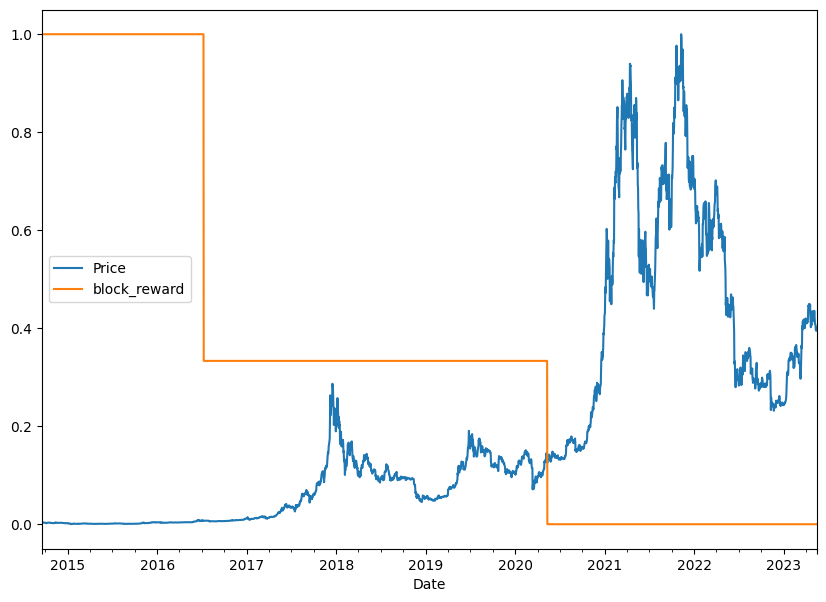

In [47]:
scaled_price_block_df.plot(figsize=(10,7));

### Making a windowed dataset with pandas for Multivariate Data

In [48]:
HORIZON = 1
WINDOW_SIZE = 7

In [49]:
bitcoin_prices_scaled_windowed = scaled_price_block_df.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_scaled_windowed[f"Price+{i+1}"] = bitcoin_prices_scaled_windowed["Price"].shift(periods=i+1)

bitcoin_prices_scaled_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,0.004144,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,0.003655,1.0,0.004144,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,0.003216,1.0,0.003655,0.004144,NaN,NaN,NaN,NaN,NaN
2014-09-20,0.003425,1.0,0.003216,0.003655,0.004144,NaN,NaN,NaN,NaN
2014-09-21,0.003275,1.0,0.003425,0.003216,0.003655,0.004144,NaN,NaN,NaN


We need to drop the NaNs and make feature set and label set

In [50]:
X = bitcoin_prices_scaled_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_scaled_windowed.dropna()["Price"].astype(np.float32)

# Make train and test split
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

X_train.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,1.0,0.003824,0.003325,0.003275,0.003425,0.003216,0.003655,0.004144
2014-09-25,1.0,0.003637,0.003824,0.003325,0.003275,0.003425,0.003216,0.003655
2014-09-26,1.0,0.003465,0.003637,0.003824,0.003325,0.003275,0.003425,0.003216
2014-09-27,1.0,0.003358,0.003465,0.003637,0.003824,0.003325,0.003275,0.003425
2014-09-28,1.0,0.003286,0.003358,0.003465,0.003637,0.003824,0.003325,0.003275


In [51]:
y_train.head()

Date
2014-09-24    0.003637
2014-09-25    0.003465
2014-09-26    0.003358
2014-09-27    0.003286
2014-09-28    0.002954
Name: Price, dtype: float32

### Experiment on model_6 (Dense model)

In [52]:
import tensorflow as tf

tf.random.set_seed(17)

# Create the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_6_dense_multivariate')

# compile the model
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            verbose=1,
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.0421 - mae: 0.0421 

20/20 [==============================] - 3s 72ms/step - loss: 0.0421 - mae: 0.0421 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 2/100
17/20 [========================>.....] - ETA: 0s - loss: 0.0123 - mae: 0.0123

20/20 [==============================] - 1s 49ms/step - loss: 0.0120 - mae: 0.0120 - val_loss: 0.0257 - val_mae: 0.0257
Epoch 3/100
18/20 [==========================>...] - ETA: 0s - loss: 0.0079 - mae: 0.0079

20/20 [==============================] - 1s 50ms/step - loss: 0.0078 - mae: 0.0078 - val_loss: 0.0190 - val_mae: 0.0190
Epoch 4/100
13/20 [==================>...........] - ETA: 0s - loss: 0.0066 - mae: 0.0066

20/20 [==============================] - 1s 28ms/step - loss: 0.0063 - mae: 0.0063 - val_loss: 0.0162 - val_mae: 0.0162
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0058

20/20 [==============================] - 1s 32ms/step - loss: 0.0058 - mae: 0.0058 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0057 - mae: 0.0057 - val_loss: 0.0159 - val_mae: 0.0159
Epoch 7/100
14/20 [====================>.........] - ETA: 0s - loss: 0.0055 - mae: 0.0055

20/20 [==============================] - 1s 38ms/step - loss: 0.0056 - mae: 0.0056 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0054 - mae: 0.0054 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 9/100
14/20 [====================>.........] - ETA: 0s - loss: 0.0053 - mae: 0.0053

20/20 [==============================] - 1s 38ms/step - loss: 0.0054 - mae: 0.0054 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0141 - val_mae: 0.0141
Epoch 11/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0053 - mae: 0.0053 - val_loss: 0.0158 - val_mae: 0.0158
Epoch 12/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0055 - mae: 0.0055 - val_loss: 0.0149 - val_mae: 0.0149
Epoch 13/100
16/20 [=======================>......] - ETA: 0s - loss: 0.0051 - mae: 0.0051

20/20 [==============================] - 1s 38ms/step - loss: 0.0051 - mae: 0.0051 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 14/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0050 - mae: 0.0050 - val_loss: 0.0156 - val_mae: 0.0156
Epoch 15/100
14/20 [====================>.........] - ETA: 0s - loss: 0.0054 - mae: 0.0054

20/20 [==============================] - 1s 28ms/step - loss: 0.0056 - mae: 0.0056 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0057 - mae: 0.0057 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 17/100
20/20 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0050

20/20 [==============================] - 1s 26ms/step - loss: 0.0050 - mae: 0.0050 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 20/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0052 - mae: 0.0052

20/20 [==============================] - 1s 29ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0124 - val_mae: 0.0124
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 22/100
20/20 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0047

20/20 [==============================] - 1s 27ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0124 - val_mae: 0.0124
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0048 - mae: 0.0048 - val_loss: 0.0177 - val_mae: 0.0177
Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0050

20/20 [==============================] - 1s 27ms/step - loss: 0.0050 - mae: 0.0050 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 25/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0060 - mae: 0.0060 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0060 - mae: 0.0060 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 27/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0060 - mae: 0.0060

20/20 [==============================] - 1s 26ms/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 28/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0049 - mae: 0.0049 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 29/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 30/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0048 - mae: 0.0048 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 31/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 32/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 33/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0036 - mae: 0.0036

20/20 [==============================] - 1s 40ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 35/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 36/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0049 - mae: 0.0049 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 37/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0053 - mae: 0.0053

20/20 [==============================] - 1s 26ms/step - loss: 0.0054 - mae: 0.0054 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 38/100
19/20 [===========================>..] - ETA: 0s - loss: 0.0044 - mae: 0.0044

20/20 [==============================] - 1s 26ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 41/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 42/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 45/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 

20/20 [==============================] - 1s 27ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0125 - val_mae: 0.0125
Epoch 54/100
20/20 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0044

20/20 [==============================] - 1s 28ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0118 - val_mae: 0.0118
Epoch 59/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0071 - mae: 0.0071

20/20 [==============================] - 0s 26ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0048 - mae: 0.0048 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 63/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 65/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 66/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0042 - mae: 

20/20 [==============================] - 1s 37ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 78/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 79/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 80/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 81/100
15/20 [=====================>........] - ETA: 0s - loss: 0.0045 - mae: 0.0045

20/20 [==============================] - 1s 36ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 84/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 86/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 87/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 88/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0047 - mae: 

20/20 [==============================] - 0s 25ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 90/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 92/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0049 - mae: 0.0049

20/20 [==============================] - 0s 25ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 93/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 94/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0045 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 95/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0046 - mae: 0.0046 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 96/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0041 - mae: 0.0041 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 97/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 98/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0124 - val_mae: 0.0124
Epoch 99/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 

In [53]:
# evaluate
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 0.0121 - mae: 0.0121


[0.012141028419137001, 0.012141028419137001]

In [54]:
# Load the best model and evaluate
model_6 = tf.keras.models.load_model(f"model_experiments/{model_6.name}/")
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 0.0116 - mae: 0.0116


[0.011573761701583862, 0.011573761701583862]

In [55]:
# Make predictions
model_6_preds = make_predictions(model_6, X_test)
model_6_preds[:2]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.72789246, 0.72875047], dtype=float32)>

In [56]:
# Evaluate results
model_6_results = make_evaluation(y_test, model_6_preds)
model_6_results

{'mae': 0.011573762,
 'mse': 0.0003174871,
 'rmse': 0.017818168,
 'mape': 2.3215187,
 'mase': 1.0008137}

In [57]:
model_1_results

{'mae': 0.011468021,
 'mse': 0.0003062688,
 'rmse': 0.017500537,
 'mape': 2.3045745,
 'mase': 1.0008093}

## Exercise 2

Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
  -  You can download the Bitcoin historical data for free from coindesk.com/price/bitcoin and clicking "Export Data" -> "CSV".

> We've downloaded the data upto 15th May 2023

## Exercise 3

For most of our models we used `WINDOW_SIZE=7`, but is there a better window size?
  -  Setup a series of experiments to find whether or not there's a better window size.
  -  For example, you might train 10 different models with `HORIZON=1` but with window sizes ranging from 2-12.

In [58]:
# let's view the data
prices

array([  457.334015,   424.440002,   394.79599 , ..., 26784.078125,
       26930.638672, 27192.693359])

In [59]:
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-11,27000.789063
2023-05-12,26804.990234
2023-05-13,26784.078125


We have experimented sp far with `WINDOW_SIZE = 7`, let's try with different window size with our best performing model architecture i.e `model_1` dense model with `HORIZON = 1` and various different `WINDOW_SIZE`.

So what are the different `WINDOW_SIZE` we can experiment with ?

- it will be between 2-12

In [60]:
WINDOW_SIZE_ARRAY = np.arange(2,12)
WINDOW_SIZE_ARRAY

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [61]:
def model_experiment_various_window_size(X_train, y_train, X_test, y_test, WINDOW_SIZE, HORIZON):
  """
  This function create the model experiment using model_1 architecture and return the
  evaluation metrics of that model
  """

  # set the random seed
  tf.random.set_seed(17)

  # create the model
  model = tf.keras.Sequential([
      layers.Dense(128, activation='relu'),
      layers.Dense(HORIZON, activation='linear')
  ], name=f'model_window_size_{WINDOW_SIZE}')

  # compile the model
  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())
  
  # fit the model
  model.fit(X_train,
            y_train,
            epochs=100,
            verbose=0,
            validation_data=(X_test, y_test),
            batch_size=128,
            callbacks=[create_model_checkpoint(model.name)])
  

  # load the best model
  load_model = tf.keras.models.load_model(f'model_experiments/{model.name}')

  # make predictions
  model_preds = make_predictions(load_model, X_test)

  # evaluate the prediction
  model_evaluation = make_evaluation(y_true=tf.squeeze(y_test),
                                     y_pred=model_preds)
  

  return model_evaluation

In [62]:
# Now let's create windows and also the conduct the modelling experiment
window_results = {}

for window_size in WINDOW_SIZE_ARRAY:
  # make windows and labels
  windows, labels = make_windows(x=prices, window_size=window_size)
  # make train and test split
  X_train, X_test, y_train, y_test = make_train_test_split(windows, labels)
  # modelling experiment
  window_results[f'model_window_size_{window_size}'] = model_experiment_various_window_size(X_train=X_train, 
                                                                                            X_test=X_test,
                                                                                            y_train=y_train,
                                                                                            y_test=y_test,
                                                                                            WINDOW_SIZE=window_size,
                                                                                            HORIZON=1)



20/20 [==============================] - 0s 3ms/step


20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 1ms/step


20/20 [==============================] - 0s 1ms/step


20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 1ms/step


20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 1ms/step


20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 1ms/step


In [63]:
window_results_df = pd.DataFrame(data=window_results.values(), index=list(window_results.keys()))

In [64]:
window_results_df

,mae,mse,rmse,mape,mase
model_window_size_2,755.458008,1364154.125,1167.970093,2.235336,1.000786
model_window_size_3,763.160278,1382350.625,1175.734009,2.253724,1.000810
model_window_size_4,764.662048,1393128.250,1180.308472,2.259136,1.000810
model_window_size_5,767.445801,1402816.625,1184.405640,2.267041,1.000810
model_window_size_6,761.991699,1377659.250,1173.737305,2.255838,1.000810
model_window_size_7,775.786072,1417801.125,1190.714478,2.289054,1.000810
model_window_size_8,778.350342,1415779.875,1189.865479,2.301597,1.000824
model_window_size_9,773.601257,1405159.500,1185.394287,2.290133,1.000824
model_window_size_10,796.954468,1492986.250,1221.878174,2.373070,1.000824
model_window_size_11,780.007935,1428145.500,1195.050415,2.317145,1.000824


<Figure size 1500x1000 with 0 Axes>

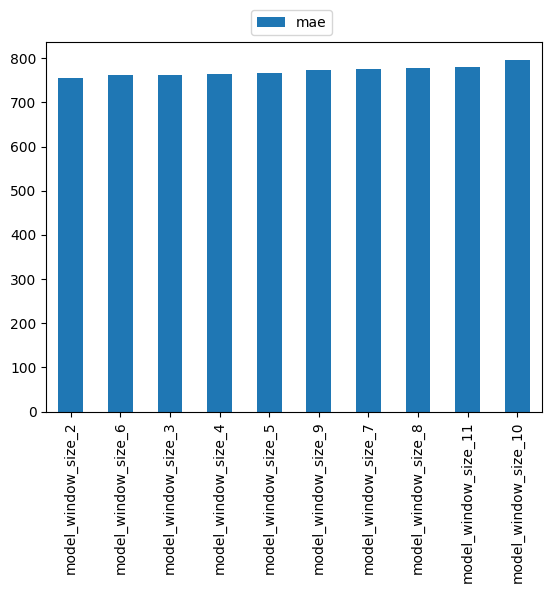

In [65]:
plt.figure(figsize=(15, 10))
window_results_df[['mae']].sort_values(by='mae').plot(kind='bar')
plt.legend(bbox_to_anchor=(0.4, 1));

Window Size = 2 has very less value for `MAE`, so it looks like our model architecture will be able to perform well with WINDOW_SIZE as 2.

## Exercise 4

Create a windowed dataset just like the ones we used for `model_1` using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) and retrain `model_1` using the recreated dataset.

In [66]:
WINDOW_SIZE = 7
HORIZON = 1

def make_train_test_splits(windows, labels, test_size = 0.2):
  split_size = int(len(windows) * (1 - test_size))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = windows[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [67]:
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=prices, targets=prices, sequence_length=WINDOW_SIZE, sequence_stride=HORIZON, 
    batch_size=128
)

In [68]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [69]:
train_size, test_size = int(0.8 * len(dataset)), int(0.2 * len(dataset))

In [70]:
train_size, test_size

(20, 5)

In [71]:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size).take(test_size)

In [72]:
# building the model 1 with the updated data
tf.random.set_seed(17)

# building simple dense model
input = layers.Input(shape=(WINDOW_SIZE,), name="Input_layer", dtype=tf.float32)
x = layers.Dense(128, activation='relu')(input)
output = layers.Dense(HORIZON, activation='linear')(x)

# packing into a model
model = tf.keras.Model(input, output)

# compile the model
model.compile(loss='mae',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae'])

# fit the model
model.fit(train_ds,
          epochs=100, verbose=0,
          validation_data=test_ds)

In [73]:
# evaluate the model
model.evaluate(test_ds)

5/5 [==============================] - 0s 15ms/step - loss: 1077.0194 - mae: 1077.0194


[1077.0194091796875, 1077.0194091796875]

## Exercise 5

For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
  - Are there any other features you think you could add?
  - If so, try it out, how do these affect the model?

In [74]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...
2023-05-13,26807.769531,27030.482422,26710.873047,26784.078125,26784.078125,9.999172e+09
2023-05-14,26788.974609,27150.976563,26661.355469,26930.638672,26930.638672,1.001486e+10
2023-05-15,26931.384766,27646.347656,26766.097656,27192.693359,27192.693359,1.441323e+10


In [75]:
import datetime

df['day_of_week'] = df.index.dayofweek
df.head()

,Open,High,Low,Close,Adj Close,Volume,day_of_week
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,2
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,3
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,4
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,5
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,6


In [76]:
# Defining the hyper parameters

HORIZON = 1
WINDOW_SIZE = 7 

In [77]:
# Our multivariate data with block reward
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [78]:
# create the windowed dataset of the above first
bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [79]:
bitcoin_prices_windowed['day_of_week'] = bitcoin_prices_windowed.index.dayofweek

In [80]:
## Getting three kinds of data (univariate, multivariate and the day of week)

# univariate data
full_windows, full_labels = make_windows_scaled(prices)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

# Multivariate data
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
X_scaled = scaler.fit_transform(X)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

# day of week
day_of_week = bitcoin_prices_windowed.dropna()['day_of_week'].to_list()

In [81]:
# Checking the shape
print(full_windows.shape, full_labels.shape)
print(X.shape, y.shape)
print(len(day_of_week))

(3156, 7) (3156, 1)
(3156, 9) (3156,)
3156


In [82]:
# Splitting the multivariate and day_of_week in train test split
split_size = int(len(X) * 0.8)
train_block_rewards, test_block_rewards = X[:split_size], X[split_size:]
train_days, test_days = day_of_week[:split_size], day_of_week[split_size:]

len(train_block_rewards), len(train_days), len(test_block_rewards), len(test_days)

(2524, 2524, 632, 632)

In [83]:
# Building a performant dataset for train and test
train_data_tribid = tf.data.Dataset.from_tensor_slices((train_windows, train_block_rewards, train_days))

train_labels_tribid = tf.data.Dataset.from_tensor_slices(train_labels)

# Test/val split
test_data_tribid = tf.data.Dataset.from_tensor_slices((test_windows, test_block_rewards, test_days))
test_labels_tribid = tf.data.Dataset.from_tensor_slices(test_labels)


# Zipping the data and labels into one complete dataset
tribid_train_ds = tf.data.Dataset.zip((train_data_tribid, train_labels_tribid))
tribid_test_ds = tf.data.Dataset.zip((test_data_tribid, test_labels_tribid))

# Applying prefetch and batching the dataset
tribid_train_ds = tribid_train_ds.batch(128).prefetch(tf.data.AUTOTUNE)
tribid_test_ds = tribid_test_ds.batch(128).prefetch(tf.data.AUTOTUNE)

tribid_train_ds, tribid_test_ds

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>)

In [84]:
# Building a tribid model
input_windows = layers.Input(shape=(7,), dtype=tf.float64, name='Windows inputs')
exp_layer_1 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input_windows)
conv1 = layers.Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu')(exp_layer_1)
window_model = tf.keras.Model(input_windows, conv1, name='Windowed Model')


input_blocks = layers.Input(shape=(9,), dtype=tf.float32, name='Block rewards inputs')
exp_layer_2 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input_blocks)
conv2 = layers.Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu')(exp_layer_2)
block_model = tf.keras.Model(input_blocks, conv2, name='Block rewards model')

# use expand dims to match the shape of batches (None, 1, 128)
input_days = layers.Input(shape=(1,), dtype=tf.int32, name='Day of week input')
exp_layers_3 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input_days)
dense = layers.Dense(128, activation='relu')(exp_layers_3)
days_model = tf.keras.Model(input_days, dense, name='days model')

# concatenating the inputs
concat = layers.Concatenate(name='combined_inputs')([window_model.output,
                                                     block_model.output,
                                                     days_model.output])

# create the dropout layers
dropout = layers.Dropout(0.4)(concat)
output_layer = layers.Dense(1, activation='linear')(dropout)

# Putting everything into a model
tribid_model = tf.keras.Model(inputs=[window_model.input,
                                      block_model.input,
                                      days_model.input],
                              outputs=output_layer)

tribid_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Windows inputs (InputLayer)    [(None, 7)]          0           []                               
                                                                                                  
 Block rewards inputs (InputLay  [(None, 9)]         0           []                               
 er)                                                                                              
                                                                                                  
 Day of week input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1, 7)         0           ['Windows inputs[0][0]']   

In [85]:
# compiling and fitting the model
tribid_model.compile(loss='mae',
                     optimizer='adam',
                     metrics='mae')

# fit the model
tribid_model.fit(tribid_train_ds,
                 epochs=20,
                 validation_data=tribid_test_ds,
                 verbose=2)

Epoch 1/20
20/20 - 7s - loss: 292.8245 - mae: 292.8245 - val_loss: 90.4591 - val_mae: 90.4591 - 7s/epoch - 333ms/step
Epoch 2/20
20/20 - 0s - loss: 125.5155 - mae: 125.5155 - val_loss: 99.5423 - val_mae: 99.5423 - 97ms/epoch - 5ms/step
Epoch 3/20
20/20 - 0s - loss: 56.5620 - mae: 56.5620 - val_loss: 29.3978 - val_mae: 29.3978 - 97ms/epoch - 5ms/step
Epoch 4/20
20/20 - 0s - loss: 25.4939 - mae: 25.4939 - val_loss: 15.0030 - val_mae: 15.0030 - 100ms/epoch - 5ms/step
Epoch 5/20
20/20 - 0s - loss: 12.2474 - mae: 12.2474 - val_loss: 23.2312 - val_mae: 23.2312 - 110ms/epoch - 6ms/step
Epoch 6/20
20/20 - 0s - loss: 0.8982 - mae: 0.8982 - val_loss: 0.8344 - val_mae: 0.8344 - 102ms/epoch - 5ms/step
Epoch 7/20
20/20 - 0s - loss: 0.6332 - mae: 0.6332 - val_loss: 0.5285 - val_mae: 0.5285 - 97ms/epoch - 5ms/step
Epoch 8/20
20/20 - 0s - loss: 0.4402 - mae: 0.4402 - val_loss: 0.4739 - val_mae: 0.4739 - 98ms/epoch - 5ms/step
Epoch 9/20
20/20 - 0s - loss: 0.4035 - mae: 0.4035 - val_loss: 0.4075 - val_m

In [86]:
tribid_model.evaluate(tribid_test_ds)

5/5 [==============================] - 0s 4ms/step - loss: 0.0402 - mae: 0.0402


[0.040234703570604324, 0.040234703570604324]

## Exercise 6

Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for `model_8`.

In [87]:
# creating windows on all data
bitcoin_prices_windowed = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

# Create feature and label dataset
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).to_numpy()               
y = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

# Turn all data into tensor datasets
feature_dataset_all = tf.data.Dataset.from_tensor_slices(X)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y)

# Combine the dataset
dataset_all = tf.data.Dataset.zip((feature_dataset_all, labels_dataset_all))

# batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [88]:
# construct the ensemble model and fit with different loss functions

def get_ensemble_models(horizon=HORIZON,                        
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=['mae','mse','mape'],
                        data=dataset_all):
  """
  Return a list of num_iter models each trained on mae, mse and mape loss functions
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  for i in range(num_iter):
    # Build and fit a new model with different loss functions
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number:{i}")

      # construct a simple dense model
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(HORIZON)
      ])

      # compile a model
      model.compile(loss=f"{loss_function}",
                    optimizer='adam',
                    metrics=['mae','mse'])
      
      # fit the model
      model.fit(data,
                epochs=num_epochs,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                                patience=100,
                                                                verbose=1)])
      
      # append the fit model
      ensemble_models.append(model)
  
  return ensemble_models

In [89]:
%%time
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number:0

Epoch 106: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 353: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number:0

Epoch 900: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number:0

Epoch 287: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number:1

Epoch 158: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 465: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number:1

Epoch 755: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 855: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing:

In [90]:
ensemble_models

In [91]:
# make a function for prediction on ensemble models
def make_ensemble_predictions(models, test_data):
  ensemble_preds = []
  for model in models:
    preds = model.predict(test_data, verbose=0)
    ensemble_preds.append(preds)

  # we have 15 model predictions, so let's take the median of those preds and return as one
  ensemble_preds_median = np.median(tf.constant(tf.squeeze(ensemble_preds)), axis=0)
  
  return ensemble_preds_median

In [92]:
# make predictions on the future
INTO_FUTURE = 14 # since our bitcoin data is daily, this is for 14 days

# create a function for future predictions
def make_future_forecast(values, model, into_future, window_size) -> list:
  """
  Makes future forecast into_future steps after values ends.

  Returns future forecasts as list of floats.
  """

  # Make an empty list of future forecasts
  future_forecast = []
  last_window = values[-window_size:] # only want preds from the last window (this will get updated)

  # make into_future number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again and again (model will start to predict on it's own prediction)
    future_pred = make_ensemble_predictions(models=model, test_data=tf.expand_dims(last_window,axis=0))
    print(f'Predicting on: \n {last_window} => Prediction: {tf.squeeze(future_pred).numpy()}\n')

    # append predictions to future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # update last window with new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-window_size:]
  
  return future_forecast

In [93]:
future_forecast = make_future_forecast(values=y,
                                       model=ensemble_models,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [27658.775391 27621.755859 27000.789063 26804.990234 26784.078125
 26930.638672 27192.693359] => Prediction: 27608.07421875

Predicting on: 
 [27621.755859   27000.789063   26804.990234   26784.078125
 26930.638672   27192.693359   27608.07421875] => Prediction: 27524.083984375

Predicting on: 
 [27000.789063   26804.990234   26784.078125   26930.638672
 27192.693359   27608.07421875 27524.08398438] => Prediction: 26946.8125

Predicting on: 
 [26804.990234   26784.078125   26930.638672   27192.693359
 27608.07421875 27524.08398438 26946.8125    ] => Prediction: 26751.587890625

Predicting on: 
 [26784.078125   26930.638672   27192.693359   27608.07421875
 27524.08398438 26946.8125     26751.58789062] => Prediction: 26695.66015625

Predicting on: 
 [26930.638672   27192.693359   27608.07421875 27524.08398438
 26946.8125     26751.58789062 26695.66015625] => Prediction: 26859.2578125

Predicting on: 
 [27192.693359   27608.07421875 27524.08398438 26946.8125
 26751.587890

In [94]:
future_forecast

[27608.074,
 27524.084,
 26946.812,
 26751.588,
 26695.66,
 26859.258,
 27159.084,
 27557.379,
 27429.678,
 26889.865,
 26700.348,
 26600.129,
 26795.756,
 27126.15]

## Exercise 7

For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn't retrained for every forecast (`model_9`)?


- append pred to list -> train new model
- make a pred on new list (with new model)
- append new pred to list -> train new model
- make a pred on new list (with new model)
- append new pred to list -> train new model
- make a pred on new list (with new model)


In [95]:
HORIZON = 1
WINDOW_SIZE = 7

def get_model(horizon=HORIZON):
  """
  Return a compiled dense model
  """
  model = tf.keras.Sequential([
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(horizon)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())
  
  return model

In [96]:
# making the data and labels for window size of 7 and horizon 1
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [115]:
# making future forecast of bitcoin prices (using the whole data)
def pred_model_run(values, X, model, into_future, epochs, window_size, horizon):
  """
  This function train a model for every updated predictions.

  Arguments:
  ----------
    - values --> labels / truth values. Bitcoin prices
    - X --> Windowed data of the bitcoin prices (default window size is 7)
    - model --> compiled model with default horizon 1
    - into_future --> how many time steps to predict in the future ?
    - window_size --> default is 7 (using the 7 days prices of bitcoin)
    - horizon --> default is 1 (predicting the price of next day)

  Returns:
  ----------
    - model --> a model that has been trained on all the previous predictions + the data
  """

  last_windows = values[-window_size:]
  X_all = X
  y_all = values
  future_forecast = []

  for _ in range(into_future):

    # Each time the model is trained for epochs with the updated data   
    model.fit(X_all,
              y_all,
              epochs=epochs,
              verbose=0)
    
    # make some future prediction
    future_pred = model.predict(tf.expand_dims(last_windows, axis=0))
    print(f'Predicing on: \n {last_windows} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

    # append the future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # update the data
    for i in range(0, len(X_all)):
      x = X_all[i][1:] # removing the 0th index of the X window
      y = y_all[1:] # removing the 0th index of y 
      X = np.append(x, future_pred)
      values = np.append(y, future_pred)
  


    # update last window with new pred and get WINDOW_SIZE most recent preds
    last_windows = np.append(last_windows, future_pred)[-window_size:]   
  
  return model   

In [100]:
full_windows.shape, full_labels.shape

((3156, 7), (3156, 1))

In [ ]:
#  using the above function
trained_model = pred_model_run(
    values=tf.squeeze(full_labels),
    X=full_windows,
    model = get_model(1),
    window_size = WINDOW_SIZE,
    horizon=HORIZON,
    epochs=10,
    into_future=14
)

1/1 [==============================] - 0s 48ms/step
Predicing on: 
 [27658.775391 27621.755859 27000.789063 26804.990234 26784.078125
 26930.638672 27192.693359] --> Prediction: 27716.646484375

1/1 [==============================] - 0s 18ms/step
Predicing on: 
 [27621.755859   27000.789063   26804.990234   26784.078125
 26930.638672   27192.693359   27716.64648438] --> Prediction: 26857.421875

1/1 [==============================] - 0s 27ms/step
Predicing on: 
 [27000.789063   26804.990234   26784.078125   26930.638672
 27192.693359   27716.64648438 26857.421875  ] --> Prediction: 26621.16796875

